# Sentiment Based Trading Strategy

## Import Libraries

In [15]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import numpy as np
import matplotlib.pyplot as plt


## Apply Relevance

In [16]:
"""
from sentence_transformers import SentenceTransformer, util

# Load semantic model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Define reference query
btc_query = "Bitcoin cryptocurrency blockchain BTC halving"

# Encode reference and articles
btc_embedding = model.encode(btc_query, convert_to_tensor=True)
texts = (news_df['TITLE'] + ". " + news_df['CONTENT']).fillna('').tolist()
text_embeddings = model.encode(texts, convert_to_tensor=True)

# Compute cosine similarity as relevance score
import torch
scores = util.cos_sim(text_embeddings, btc_embedding).squeeze().cpu().numpy()
news_df['btc_relevance_score'] = scores
"""

'\nfrom sentence_transformers import SentenceTransformer, util\n\n# Load semantic model\nmodel = SentenceTransformer(\'all-MiniLM-L6-v2\')\n\n# Define reference query\nbtc_query = "Bitcoin cryptocurrency blockchain BTC halving"\n\n# Encode reference and articles\nbtc_embedding = model.encode(btc_query, convert_to_tensor=True)\ntexts = (news_df[\'TITLE\'] + ". " + news_df[\'CONTENT\']).fillna(\'\').tolist()\ntext_embeddings = model.encode(texts, convert_to_tensor=True)\n\n# Compute cosine similarity as relevance score\nimport torch\nscores = util.cos_sim(text_embeddings, btc_embedding).squeeze().cpu().numpy()\nnews_df[\'btc_relevance_score\'] = scores\n'

## Apply Sentiment

In [17]:
"""
!pip install vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Apply sentiment on title + content
def get_sentiment(text):
    if pd.isna(text):
        return 0.0
    return analyzer.polarity_scores(text)['compound']

filtered_news['text'] = filtered_news['TITLE'] + ". " + filtered_news['CONTENT']
filtered_news['sentiment'] = filtered_news['text'].apply(get_sentiment)
"""

'\n!pip install vaderSentiment\n\nfrom vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer\nanalyzer = SentimentIntensityAnalyzer()\n\n# Apply sentiment on title + content\ndef get_sentiment(text):\n    if pd.isna(text):\n        return 0.0\n    return analyzer.polarity_scores(text)[\'compound\']\n\nfiltered_news[\'text\'] = filtered_news[\'TITLE\'] + ". " + filtered_news[\'CONTENT\']\nfiltered_news[\'sentiment\'] = filtered_news[\'text\'].apply(get_sentiment)\n'

## Train Set Gridsearch

In [18]:
import pandas as pd
import numpy as np
from itertools import product

btc_df = pd.read_csv("BTC-USD.csv")
btc_df['date'] = pd.to_datetime(btc_df['Time'], unit='s')
btc_df = btc_df[['date', 'Open', 'High', 'Low', 'Close', 'Volume']]

news_df = pd.read_csv("filtered_crypto_news_with_sentiment.csv")
news_df['date'] = pd.to_datetime(news_df['date'])

train_start = pd.Timestamp("2018-05-01")
train_end = pd.Timestamp("2022-12-31")

# Filter BTC and News to train window
btc_df = btc_df[(btc_df['date'] >= train_start) & (btc_df['date'] <= train_end)].copy()
news_df = news_df[(news_df['date'] >= train_start) & (news_df['date'] <= train_end)].copy()

risk_free_rate_annual = 0.02
transaction_cost_pct = 0.001
slippage_pct = 0.0015
total_cost_per_leg = transaction_cost_pct + slippage_pct
transaction_cost_per_leg_log = np.log(1 - total_cost_per_leg)

def calculate_max_drawdown(cumulative_returns):
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

def run_strategy(relevance_threshold, sentiment_threshold, smoothing_window, stop_loss_pct):

    filtered_news = news_df[news_df['btc_relevance_score'] > relevance_threshold].copy()
    daily_sentiment = (
        filtered_news.groupby('date')['sentiment']
        .mean()
        .reset_index()
        .rename(columns={'sentiment': 'avg_sentiment'})
    )
    daily_sentiment['signal_date'] = daily_sentiment['date'] + pd.Timedelta(days=1)
    daily_sentiment = daily_sentiment.drop(columns=['date'])

    merged = pd.merge(btc_df, daily_sentiment, left_on='date', right_on='signal_date', how='left')
    merged = merged.drop(columns=['signal_date'])
    merged['avg_sentiment'] = merged['avg_sentiment'].fillna(0.0)
    merged['smoothed_sentiment'] = merged['avg_sentiment'].rolling(window=smoothing_window, min_periods=1).mean()
    merged['log_daily_return'] = np.log(merged['Close'] / merged['Open'])

    def scaled_signal(sentiment):
        if abs(sentiment) < sentiment_threshold:
            return 0.0
        return np.clip(sentiment / 1.0, -1.0, 1.0)

    merged['raw_signal'] = merged['smoothed_sentiment'].apply(scaled_signal)

    merged['position_actual'] = 0.0
    merged['entry_price_actual'] = np.nan
    merged['strategy_log_return'] = 0.0

    for i in range(1, len(merged)):
        signal_today = merged.loc[i, 'raw_signal']
        prev_pos = merged.loc[i-1, 'position_actual']
        prev_entry = merged.loc[i-1, 'entry_price_actual']

        current_open = merged.loc[i, 'Open']
        current_high = merged.loc[i, 'High']
        current_low = merged.loc[i, 'Low']
        effective_return = merged.loc[i, 'log_daily_return']

        temp_pos = prev_pos
        temp_entry = prev_entry

        if signal_today != 0 and signal_today != prev_pos:
            temp_pos = signal_today
            temp_entry = current_open

        if temp_pos > 0 and not np.isnan(temp_entry):
            sl_price = temp_entry * (1 - stop_loss_pct)
            if current_low <= sl_price:
                effective_return = np.log(sl_price / current_open)
                temp_pos = 0.0
                temp_entry = np.nan
        elif temp_pos < 0 and not np.isnan(temp_entry):
            sl_price = temp_entry * (1 + stop_loss_pct)
            if current_high >= sl_price:
                effective_return = np.log(current_open / sl_price)
                temp_pos = 0.0
                temp_entry = np.nan

        merged.loc[i, 'position_actual'] = temp_pos
        merged.loc[i, 'entry_price_actual'] = temp_entry
        merged.loc[i, 'strategy_log_return'] = temp_pos * effective_return

        if temp_pos != prev_pos:
            merged.loc[i, 'strategy_log_return'] += transaction_cost_per_leg_log

    log_ret = merged['strategy_log_return'].dropna()

    gains = log_ret[log_ret > 0].sum()
    losses = -log_ret[log_ret < 0].sum()

    profit_factor = gains / losses if losses > 0 else np.nan
    daily_risk_free = (1 + risk_free_rate_annual) ** (1 / 365) - 1
    excess = log_ret - daily_risk_free
    sharpe = (excess.mean() / excess.std()) * np.sqrt(365) if excess.std() else np.nan
    n = len(excess)
    if n > 1 and excess.std() != 0:
        sharpe_se = excess.std(ddof=1) / np.sqrt(n)
        sharpe_ci_lower = sharpe - 1.96 * sharpe_se * np.sqrt(365)
        sharpe_ci_upper = sharpe + 1.96 * sharpe_se * np.sqrt(365)
    else:
        sharpe_ci_lower, sharpe_ci_upper = np.nan, np.nan

    downside_returns = excess[excess < 0]
    downside_std = downside_returns.std()
    sortino_ratio = (excess.mean() / downside_std) * np.sqrt(365) if downside_std > 0 else np.nan
    win_rate = (log_ret > 0).mean()

    merged['signal_diff'] = merged['position_actual'].diff().fillna(0)
    num_trades = ((merged['signal_diff'] != 0) & (merged['position_actual'] != 0)).sum()
    ann_return = (np.exp(log_ret.mean() * 365) - 1) * 100
    max_dd = calculate_max_drawdown(np.exp(log_ret.cumsum()))

    calmar_ratio = ann_return / abs(max_dd) if abs(max_dd) > 0 else np.nan

    return {
    "Sharpe": sharpe,
    "Sharpe_CI_Lower": sharpe_ci_lower,
    "Sharpe_CI_Upper": sharpe_ci_upper,
    "Annualized Return": ann_return,
    "Max Drawdown": max_dd,
    "Num Trades": num_trades,
    "Win Rate": win_rate,
    "Profit Factor": profit_factor,
    "Sortino Ratio": sortino_ratio,
    "Calmar Ratio": calmar_ratio,
    "Relevance": relevance_threshold,
    "Sentiment": sentiment_threshold,
    "Window": smoothing_window,
    "StopLoss": stop_loss_pct
    }

# Grid Search Configuration
relevance_vals = [0.2, 0.3, 0.4]
sentiment_vals = [0.2, 0.3, 0.4, 0.5]
window_vals = [3, 5, 7]
stop_vals = [0.03, 0.05, 0.08]

results = []
for r, s, w, sl in product(relevance_vals, sentiment_vals, window_vals, stop_vals):
    try:
        result = run_strategy(r, s, w, sl)
        results.append(result)
    except Exception as e:
        print(f"Failed for {r}, {s}, {w}, {sl}: {e}")

# Save results to CSV
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Sharpe", ascending=False).reset_index(drop=True)
results_df.to_csv("sentiment_gridsearch_result.csv", index=False)

print("\n Grid search complete. Results saved to 'sentiment_gridsearch_result.csv'")



 Grid search complete. Results saved to 'sentiment_gridsearch_result.csv'


## Test Set Evaluation

In [19]:
import pandas as pd
import numpy as np
from itertools import product


btc_df = pd.read_csv("BTC-USD.csv")
btc_df['date'] = pd.to_datetime(btc_df['Time'], unit='s')
btc_df = btc_df[['date', 'Open', 'High', 'Low', 'Close', 'Volume']]

news_df = pd.read_csv("filtered_crypto_news_with_sentiment.csv")
news_df['date'] = pd.to_datetime(news_df['date'])

test_start = pd.Timestamp("2023-01-01")
test_end = pd.Timestamp("2025-01-31")

btc_df = btc_df[(btc_df['date'] >= test_start) & (btc_df['date'] <= test_end)].copy()
news_df = news_df[(news_df['date'] >= test_start) & (news_df['date'] <= test_end)].copy()

risk_free_rate_annual = 0.02
transaction_cost_pct = 0.001
slippage_pct = 0.0015
total_cost_per_leg = transaction_cost_pct + slippage_pct
transaction_cost_per_leg_log = np.log(1 - total_cost_per_leg)

def calculate_max_drawdown(cumulative_returns):
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

def run_strategy(relevance_threshold, sentiment_threshold, smoothing_window, stop_loss_pct):
    filtered_news = news_df[news_df['btc_relevance_score'] > relevance_threshold].copy()
    daily_sentiment = (
        filtered_news.groupby('date')['sentiment']
        .mean()
        .reset_index()
        .rename(columns={'sentiment': 'avg_sentiment'})
    )
    daily_sentiment['signal_date'] = daily_sentiment['date'] + pd.Timedelta(days=1)
    daily_sentiment = daily_sentiment.drop(columns=['date'])

    merged = pd.merge(btc_df, daily_sentiment, left_on='date', right_on='signal_date', how='left')
    merged = merged.drop(columns=['signal_date'])
    merged['avg_sentiment'] = merged['avg_sentiment'].fillna(0.0)
    merged['smoothed_sentiment'] = merged['avg_sentiment'].rolling(window=smoothing_window, min_periods=1).mean()
    merged['log_daily_return'] = np.log(merged['Close'] / merged['Open'])

    def scaled_signal(sentiment):
        if abs(sentiment) < sentiment_threshold:
            return 0.0
        return np.clip(sentiment / 1.0, -1.0, 1.0)

    merged['raw_signal'] = merged['smoothed_sentiment'].apply(scaled_signal)

    merged['position_actual'] = 0.0
    merged['entry_price_actual'] = np.nan
    merged['strategy_log_return'] = 0.0

    for i in range(1, len(merged)):
        signal_today = merged.loc[i, 'raw_signal']
        prev_pos = merged.loc[i-1, 'position_actual']
        prev_entry = merged.loc[i-1, 'entry_price_actual']

        current_open = merged.loc[i, 'Open']
        current_high = merged.loc[i, 'High']
        current_low = merged.loc[i, 'Low']
        effective_return = merged.loc[i, 'log_daily_return']

        temp_pos = prev_pos
        temp_entry = prev_entry

        if signal_today != 0 and signal_today != prev_pos:
            temp_pos = signal_today
            temp_entry = current_open

        if temp_pos > 0 and not np.isnan(temp_entry):
            sl_price = temp_entry * (1 - stop_loss_pct)
            if current_low <= sl_price:
                effective_return = np.log(sl_price / current_open)
                temp_pos = 0.0
                temp_entry = np.nan
        elif temp_pos < 0 and not np.isnan(temp_entry):
            sl_price = temp_entry * (1 + stop_loss_pct)
            if current_high >= sl_price:
                effective_return = np.log(current_open / sl_price)
                temp_pos = 0.0
                temp_entry = np.nan

        merged.loc[i, 'position_actual'] = temp_pos
        merged.loc[i, 'entry_price_actual'] = temp_entry
        merged.loc[i, 'strategy_log_return'] = temp_pos * effective_return

        if temp_pos != prev_pos:
            merged.loc[i, 'strategy_log_return'] += transaction_cost_per_leg_log

        log_ret = merged['strategy_log_return'].dropna()

    gains = log_ret[log_ret > 0].sum()
    losses = -log_ret[log_ret < 0].sum()

    profit_factor = gains / losses if losses > 0 else np.nan
    daily_risk_free = (1 + risk_free_rate_annual) ** (1 / 365) - 1
    excess = log_ret - daily_risk_free
    sharpe = (excess.mean() / excess.std()) * np.sqrt(365) if excess.std() else np.nan
    n = len(excess)
    if n > 1 and excess.std() != 0:
        sharpe_se = excess.std(ddof=1) / np.sqrt(n)
        sharpe_ci_lower = sharpe - 1.96 * sharpe_se * np.sqrt(365)
        sharpe_ci_upper = sharpe + 1.96 * sharpe_se * np.sqrt(365)
    else:
        sharpe_ci_lower, sharpe_ci_upper = np.nan, np.nan

    downside_returns = excess[excess < 0]
    downside_std = downside_returns.std()
    sortino_ratio = (excess.mean() / downside_std) * np.sqrt(365) if downside_std > 0 else np.nan
    win_rate = (log_ret > 0).mean()


    merged['signal_diff'] = merged['position_actual'].diff().fillna(0)
    num_trades = ((merged['signal_diff'] != 0) & (merged['position_actual'] != 0)).sum()
    ann_return = (np.exp(log_ret.mean() * 365) - 1) * 100
    max_dd = calculate_max_drawdown(np.exp(log_ret.cumsum()))

    calmar_ratio = (ann_return / 100) / abs(max_dd) if abs(max_dd) > 0 else np.nan

    merged['cumulative_strategy'] = np.exp(merged['strategy_log_return'].cumsum())

    merged['benchmark_log_return'] = np.log(merged['Close'] / merged['Open'])
    merged['cumulative_benchmark'] = np.exp(merged['benchmark_log_return'].cumsum())

    return {
    "Sharpe": sharpe,
    "Sharpe_CI_Lower": sharpe_ci_lower,
    "Sharpe_CI_Upper": sharpe_ci_upper,
    "Annualized Return": ann_return,
    "Max Drawdown": max_dd,
    "Num Trades": num_trades,
    "Win Rate": win_rate,
    "Profit Factor": profit_factor,
    "Sortino Ratio": sortino_ratio,
    "Calmar Ratio": calmar_ratio,
    "Relevance": relevance_threshold,
    "Sentiment": sentiment_threshold,
    "Window": smoothing_window,
    "StopLoss": stop_loss_pct,
    "merged_df": merged
    }


relevance_threshold = 0.2
sentiment_threshold = 0.2
smoothing_window = 7
stop_loss_pct = 0.03

result = run_strategy(relevance_threshold, sentiment_threshold, smoothing_window, stop_loss_pct)
for k, v in result.items():
    print(f"{k}: {v}")



Sharpe: 2.917312928728635
Sharpe_CI_Lower: 2.901617088792685
Sharpe_CI_Upper: 2.9330087686645845
Annualized Return: 93.81408486583763
Max Drawdown: -0.18017507981585162
Num Trades: 575
Win Rate: 0.39072847682119205
Profit Factor: 1.6632454912868995
Sortino Ratio: 8.398386722902265
Calmar Ratio: 520.6829099879991
Relevance: 0.2
Sentiment: 0.2
Window: 7
StopLoss: 0.03
merged_df:           date       Open       High        Low      Close        Volume  \
0   2025-01-24  103926.36  107200.00  102751.92  104490.65  12791.293456   
1   2025-01-23  103659.60  106870.87  101200.01  103926.36  25064.864999   
2   2025-01-22  106159.27  106431.34  103100.00  103667.11  10730.018962   
3   2025-01-21  102145.42  107291.10  100051.00  106159.26  19411.234890   
4   2025-01-20  101217.78  109358.01   99416.27  102145.43  32342.183113   
..         ...        ...        ...        ...        ...           ...   
750 2023-01-05   16844.40   16872.13   16750.07   16825.69  14918.229133   
751 2023-01-

## Benchmark Comparison



 Benchmark Performance (Buy and Hold BTC)
Benchmark Total Return:      532.06%
Benchmark Annualized Return: 144.20%
Benchmark Max Drawdown:      -26.15%


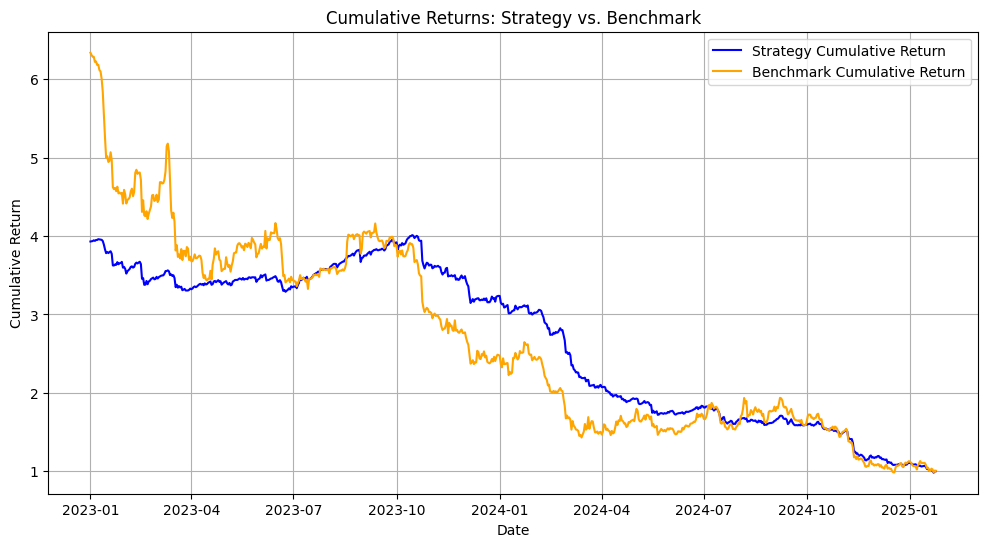

In [20]:
btc_merged = result['merged_df']

benchmark_log_ret = btc_merged['benchmark_log_return']

benchmark_start_price = btc_merged.loc[btc_merged['date'] == btc_merged['date'].min(), 'Open'].iloc[0]
benchmark_end_price = btc_merged.loc[btc_merged['date'] == btc_merged['date'].max(), 'Close'].iloc[0]
benchmark_total_return_pct = ((benchmark_end_price / benchmark_start_price) - 1) * 100

benchmark_annualized_log_return = benchmark_log_ret.mean() * 365
benchmark_annualized_return_pct = (np.exp(benchmark_annualized_log_return) - 1) * 100

benchmark_max_drawdown = calculate_max_drawdown(btc_merged['cumulative_benchmark'])

print("\n Benchmark Performance (Buy and Hold BTC)")
print(f"Benchmark Total Return:      {benchmark_total_return_pct:.2f}%")
print(f"Benchmark Annualized Return: {benchmark_annualized_return_pct:.2f}%")
print(f"Benchmark Max Drawdown:      {benchmark_max_drawdown:.2%}")

plt.figure(figsize=(12, 6))
plt.plot(btc_merged['date'], btc_merged['cumulative_strategy'], label='Strategy Cumulative Return', color='blue')
plt.plot(btc_merged['date'], btc_merged['cumulative_benchmark'], label='Benchmark Cumulative Return', color='orange')
plt.title('Cumulative Returns: Strategy vs. Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()